# Starting Kit - FAIR UNIVERSE: HIGGSML UNCERTAINTY CHALLENGE

***
## **Introduction**
***
In 2012, the Nobel-prize-winning discovery of the Higgs Boson by the ATLAS and CMS experiments at the Large Hadron Collider (LHC) at CERN in Geneva, Switzerland was a major milestone in the history of physics. However, despite the validation it provided of the Standard Model of particle physics (SM), there are still numerous questions in physics that the SM does not answer. One promissing approach to uncover some of these mysteries is to study the Higgs Boson in great detail, as the rate of Higgs Boson production and its decay properties may hold the secrets to the nature of dark matter and other phenomena not explained by the SM.

The LHC collides protons together at high energy and at a high rate. Each proton collision produces many outgoing particles. A small fraction of the time, a Higgs boson is produced and then decays into other particles that can be detected by experiments such as ATLAS and CMS. In this challenge we focus on the Higgs boson decay to two $\tau$ particles which themselves further decay into other particles before being detected. Measuring this “signal” of interest is complicated by the presence of “background” decays which can produce the same detector signatures. The aim of this challenge is to determine methods to improve the precision of the Higgs boson production rate (“signal strength” or $\mu$), which is defined below, based on feature variables that are derived from simulated measurements made in an ATLAS-like detector. This builds on a previous [Kaggle challenge](https://www.kaggle.com/c/higgs-boson) but focuses directly on the statistical inference, where the goal is not only to isolate Higgs boson events (previous challenge), but to determine the precision on $\mu$ in the presence of uncertainty. Technical details on the signal and background decay channels and features of the dataset are given below, but participants not familiar with particle physics can consider any of these simply as input feature variables for their proposed method except the EventId, Weight and Label (which is essentially the target).

### **Problem Setting**
***
The objective of this challenge is to improve the signal strength of the Higgs boson decay, specifically in the $H \rightarrow \tau \tau$ decay mode and in the 1 lepton 1 hadron decay channel and in the presence of the background $Z \rightarrow \tau \tau$ process. Additionally, there are systematic uncertainties, specifically in this dataset applied to the Tau Energy Scale (TES).

**The following are the features in this data set.**


|     | Variable                     | Description                                                                                       |
| --- | ---------------------------- | ------------------------------------------------------------------------------------------------- |
| 1.  | EventId                      | A unique integer identifier of the event. {should **NOT** be used for training} |
| 2.  | DER_mass_transverse_met_lep  | The transverse mass between the missing transverse energy and the lepton.                         |
| 3.  | DER_mass_vis                 | The invariant mass of the hadronic tau and the lepton.                                           |
| 4.  | DER_pt_h                     | The modulus of the vector sum of the transverse momentum of the hadronic tau, the lepton and the missing transverse energy vector. |
| 5.  | DER_deltaeta_jet_jet         | The absolute value of the pseudorapidity separation between the two jets (undefined if PRI_jet_num ≤ 1). |
| 6.  | DER_mass_jet_jet             | The invariant mass of the two jets (undefined if PRI_jet_num ≤ 1).                                |
| 7.  | DER_prodeta_jet_jet          | The product of the pseudorapidities of the two jets (undefined if PRI_jet_num ≤ 1).              |
| 8.  | DER_deltar_had_lep           | The R separation between the hadronic tau and the lepton.                                        |
| 9. | DER_pt_tot                   | The modulus of the vector sum of the missing transverse momenta and the transverse momenta of the hadronic tau, the lepton, the leading jet (if PRI_jet_num ≥ 1) and the subleading jet (if PRI_jet_num = 2) (but not of any additional jets). |
| 10. | DER_sum_pt                   | The sum of the moduli of the transverse momenta of the hadronic tau, the lepton, the leading jet (if PRI_jet_num ≥ 1) and the subleading jet (if PRI_jet_num = 2) and the other jets (if PRI_jet_num = 3). |
| 11. | DER_pt_ratio_lep_tau         | The ratio of the transverse momenta of the lepton and the hadronic tau.                           |
| 12. | DER_met_phi_centrality       | The centrality of the azimuthal angle of the missing transverse energy vector w.r.t. the hadronic tau and the lepton. |
| 13. | DER_lep_eta_centrality       | The centrality of the pseudorapidity of the lepton w.r.t. the two jets (undefined if PRI_jet_num ≤ 1). |
| 14. | Eletron Flag                 | 1 if it is an electron 0 if it not.                                                               |
| 15. | muon Flag                    | 1 if it is a muon 0 if it not.                                                                   |
| 16. | PRI_had_pt                   | The transverse momentum $\sqrt{{p_x}^2 + {p_x}^2}$ of the hadronic tau.                          |
| 17. | PRI_had_eta                  | The pseudorapidity $\eta$ of the hadronic tau.                                                    |
| 18. | PRI_had_phi                  | The azimuth angle $\phi$ of the hadronic tau.                                                     |
| 19. | PRI_lep_pt                   | The transverse momentum $\sqrt{{p_x}^2 + {p_x}^2}$ of the lepton (electron or muon).             |
| 20. | PRI_lep_eta                  | The pseudorapidity $\eta$ of the lepton.                                                           |
| 21. | PRI_lep_phi                  | The azimuth angle $\phi$ of the lepton.                                                            |
| 22. | PRI_met                      | The missing transverse energy $\overrightarrow{E}^{miss}_{T}$.                                    |
| 23. | PRI_met_phi                  | The azimuth angle $\phi$ of the missing transverse energy.                                        |
| 24. | PRI_jet_num                  | The number of jets (integer with a value of 0, 1, 2 or 3; possible larger values have been capped at 3). |
| 25. | PRI_jet_leading_pt           | The transverse momentum $\sqrt{{p_x}^2 + {p_x}^2}$ of the leading jet, that is the jet with the largest transverse momentum (undefined if PRI_jet_num = 0). |
| 26. | PRI_jet_leading_eta          | The pseudorapidity $\eta$ of the leading jet (undefined if PRI_jet_num = 0).                     |
| 27. | PRI_jet_leading_phi          | The azimuth angle $\phi$ of the leading jet (undefined if PRI_jet_num = 0).                      |
| 28. | PRI_jet_subleading_pt        | The transverse momentum $\sqrt{{p_x}^2 + {p_x}^2}$ of the leading jet, that is, the jet with the second largest transverse momentum (undefined if PRI_jet_num ≤ 1). |
| 29. | PRI_jet_subleading_eta       | The pseudorapidity $\eta$ of the subleading jet (undefined if PRI_jet_num ≤ 1).                  |
| 30. | PRI_jet_subleading_phi       | The azimuth angle $\phi$ of the subleading jet (undefined if PRI_jet_num ≤ 1).                   |
| 31. | PRI_jet_all_pt               | The scalar sum of the transverse momentum of all the jets of the events.                          |
| 32. | Weight                       | The event weight $w_i$.  {should **NOT** be used for training}                                                                         |
| 33. | Label                        | The event label $y_i \in \{1,0\}$ (1 for signal, 0 for background). {should **NOT** be used for training}                               |


### Classifier method
Narrowing down the number of events to be considered to a Region Of Interest (ROI), rich in signal events, putting a threshold on the output of a classifier providing $Proba(y=signal|{\bf x})$, then apply the estimator:

$\Large \hat{\mu} = \frac{N_{ROI} - \beta_{ROI}}{\gamma_{ROI}}$

In the presence of weights, the number of events is given by the sum of weights


$ w_{pseudo} = Poisson(w_i)$, where $w_i$ the weights of event i 

$N_{pseudo} = \sum_{i = 0}^l w_{pseudo}$ where l is the number of elements in one pseudo dataset

$N_{ROI_{BS}} = \frac{\sum_{i = 0}^m N_{pseudo}}{m} $  where m is the number of pseudo datasets

$\sigma_{ROI_{BS}} =  \frac{\sum_{i = 0}^m (N_{pseudo} - N_{ROI_{BS}} )^2}{m}$

$\gamma_{ROI} = \sum_{i = 0}^n w_{eval}  \forall i \in {S} $ number of signal events in ROI in evaluation set

$\beta_{ROI} = \sum_{i = 0}^n w_{eval}   \forall i \in {B} $ number of Background events in ROI in evaluation set

$\Large \hat{\mu} =  \frac{N_{ROI_{BS}} - \beta_{ROI}}{\gamma_{ROI}}   $

$\Delta \hat{\mu} = |\frac{\sigma_{ROI_{BS}} - \beta_{ROI}}{\gamma_{ROI}}|$

This estimator has variance:

$\Large \sigma^2_{\hat{\mu}} = \frac{\nu_{ROI}}{\gamma_{ROI}^2} $

which is lower than that of the plain Poisson counting process, if and only if  $\gamma_{ROI}$. $\gamma_{ROI} / \nu_{ROI}$ > $\gamma$ . $\gamma / \nu$. We see that $\gamma_{ROI} / \nu_{ROI}$ > $\gamma / \nu$ is NOT a sufficient condition to lower the variance of the estimator of $\mu$. There is a tradeoff between increasing $\gamma_{ROI} / \nu_{ROI}$ and not decreasing $\gamma_{ROI}$ too much, that is going into regions "enriched" in signal, but in which the total number of signal events approaches 0.

Here $\gamma_{ROI}$ and $\beta_{ROI}$ are NOT assumed to be known constants (like in the histogram method); they need to be estimated with the simulator, and, likewise, could be plagued with systematic error. Thus, in the presence of systematics, this simple estimator underestimates the variance of $\hat{\mu}$. **This is the problem we want to solve.**


***
# Setup
***
Use `COLAB` = `True` if you are running this notebook in [Google Colab](https://colab.research.google.com), otherwise set `COLAB` = `False`

In [1]:
COLAB=False

In [2]:
if COLAB:
    # clone github repo
    !git clone https://github.com/ihsaan-ullah/fair-universe.git

    # move to the HEP starting kit folder
    %cd fair-universe/Starting_Kits/HEP/

***
# Existing Submissions
***
By this point you should have a clone of the repo which contains the following ready submissions which you can submit to the Competition

- Dummy submission: `FU_HEP_dummy_submission.zip`
- Sample submission `FU_HEP_sample_submission.zip`

***
# Imports
***

In [3]:
import os
from sys import path
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from itertools import product
import warnings
warnings.filterwarnings("ignore")

***
# Directories
***

In [4]:
root_dir = "./"
# Input data directory to read training data from
input_dir = root_dir + "sample_data/"
reference_dir = root_dir + 'sample_data/'
# Output data directory to write predictions to
output_dir = root_dir + "sample_result_submission"
# Program directory
program_dir = root_dir + "ingestion_program"
# Score directory
score_dir = root_dir + "scoring_program"
# Directory to read submitted submissions from
submission_dir = root_dir + "sample_code_submission"

***
# Add directories to path
***

In [5]:
path.append(input_dir)
path.append(reference_dir)
path.append(output_dir)
path.append(program_dir)
path.append(submission_dir)

***
# Internal imports
***

In [6]:
from visualization import *
from systematics import Systematics

***
# Import Submission Model
***
We import a class named `Model` from the submission file (`model.py`). This `Model` class has the following methods:
- `init`: receives train set and systematics class as input
- `fit`: can be used for training
- `predict`: receives one test set and outputs a dictionary with the following keys
    - `mu_hat` : predicted mu $\hat{\mu}$
    - `delta_mu_hat`: $\Delta{\hat{\mu}}$ bound for $\mu$
    - `p16`: 16th percentile
    - `p84`: 84th percentile


### ⚠️ Note:
In real setting i.e. the challenge itself, the submitted model is initialized once with trian set and systematics class and the `predict` is called multiple times, each time with a different test sets. 

In [7]:
from model import Model

***
# Data
***
1. Load Train set
2. Load Test sets


### ⚠️ Note:
The data used here is sample data is for demonstration only to get a view of what the data looks like.

In [8]:
class Data():

  def __init__(self):

      self.train_set = None
      self.test_sets = []
      self.systematics = Systematics

      print("==========================================")
      print("Data")
      print("==========================================")

  def load_train_set(self):
    """
      - Loads train set
      - Train set has no systematics
    """
    print("[*] Loading Train set")

    train_data_file = os.path.join(input_dir, 'train', 'data', 'data.csv')
    train_labels_file = os.path.join(input_dir, 'train', 'labels', "data.labels")
    train_settings_file = os.path.join(input_dir, 'train', 'settings', "data.json")
    train_weights_file = os.path.join(input_dir, 'train', 'weights', "data.weights")

    # read train data
    train_data = pd.read_csv(train_data_file)

    # read train labels
    with open(train_labels_file, "r") as f:
        train_labels = np.array(f.read().splitlines(), dtype=float)

    # read train settings
    with open(train_settings_file) as f:
        train_settings = json.load(f)

    # read train weights
    with open(train_weights_file) as f:
        train_weights = np.array(f.read().splitlines(), dtype=float)

    self.train_set = {
        "data": train_data,
        "labels": train_labels,
        "settings": train_settings,
        "weights": train_weights
    }

  def load_test_sets(self):
    """
      - Loads test sets
    """
    print("[*] Loading Test sets")
    self.test_sets = []
    # loop over sets (1 value of mu, total 10 sets)
    for i in range(0, 10):
        test_sets_per_mu = []
        # loop over test sets, total 100 test sets
        for j in range(0, 100):
            test_data_file = os.path.join(input_dir, 'test', f'set_{i}', 'data', f'data_{j}.csv')
            test_data = pd.read_csv(test_data_file)

            test_weights_file = os.path.join(input_dir, 'test', f'set_{i}', 'weights', f'data_{j}.weights')
            with open(test_weights_file) as f:
                test_weights = np.array(f.read().splitlines(), dtype=float)

            test_lables_file = os.path.join(reference_dir, 'test', f'set_{i}', 'labels', f'data_{j}.labels')
            with open(test_lables_file) as f:
                test_labels = np.array(f.read().splitlines(), dtype=float)

            test_settings_file = os.path.join(reference_dir, 'test', f'set_{i}', "settings", "data.json")
            with open(test_settings_file) as f:
              test_settings = json.load(f)

            test_set = {
                "data": test_data,
                "labels": test_labels,
                "weights": test_weights,
                "settings": test_settings
            }
            test_sets_per_mu.append(test_set)
        self.test_sets.append(test_sets_per_mu)

In [9]:
# Initilaize data
data = Data()

Data


In [10]:
# load train set
data.load_train_set()

[*] Loading Train set


In [11]:
# load test sets
data.load_test_sets()

[*] Loading Test sets


***
# Visualize
***
- Visualize Train set

In [12]:
class Visualize():

    def __init__(self, data):

        self.train_visualize = Dataset_visualise(
            data=data.train_set["data"],
            weights=data.train_set["weights"],
            labels=data.train_set["labels"],
            name="Train Set"
        )
        print("==========================================")
        print("Visualize")
        print("==========================================")


    def show_data_summary(self):
        """
            Show Dataset summary
                - Number of events
                - Number of features
                - Number of signal events
                - Number of background events
                - mean and std of each feature and other statistical information
        """
        self.train_visualize.examine_dataset()

    def show_histogram(self):
        """
            - plot the histogram of each feature in the dataset for signal and background events,
            - for given set of columns. Columns to be plotted can be specified by the user
            - This function will take a long time to run if the number of columns is large, 
            - If no columns are given it will plot all the columns of the dataset.
        """
        columns = ['PRI_jet_leading_pt', 'PRI_met', 'DER_mass_vis', 'DER_mass_jet_jet', 'DER_deltar_lep_had', 'DER_sum_pt']
        self.train_visualize.histogram_dataset(columns=columns)

    def show_pair_plots(self):
        """ 
            This function will plot the pair plots of the features in the dataset for the given columns 
            for the signal and background events separately

            NB: 
            - This function will take a long time to run if the number of columns is large, 
            - If no columns are given it will plot all the columns of the dataset.
        """
        columns = ['PRI_lep_pt', 'PRI_lep_eta','PRI_lep_phi', 'DER_deltar_had_lep']
        self.train_visualize.pair_plots(columns=columns)


In [13]:
# Initilaize Visualize
visualize = Visualize(data=data)

Visualize


In [14]:
# Show data summary
visualize.show_data_summary()

[*] --- Dataset name : Train Set
[*] --- Number of events : 100
[*] --- Number of features : 32
[*] --- Number of signal events : 50
[*] --- Number of background events : 50
[*] --- List of all features
	PRI_lep_pt
	PRI_lep_eta
	PRI_lep_phi
	PRI_electron_flag
	PRI_muon_flag
	PRI_had_pt
	PRI_had_eta
	PRI_had_phi
	PRI_jet_leading_pt
	PRI_jet_leading_eta
	PRI_jet_leading_phi
	PRI_n_jets
	PRI_jet_subleading_pt
	PRI_jet_subleading_eta
	PRI_jet_subleading_phi
	PRI_jet_all_pt
	PRI_met
	PRI_met_phi
	DER_mass_transverse_lep_had
	DER_mass_vis
	DER_pt_h
	DER_deltaeta_jet_jet
	DER_mass_jet_jet
	DER_prodeta_jet_jet
	DER_deltar_lep_had
	DER_pt_tot
	DER_sum_pt
	DER_pt_ratio_lep_had
	DER_mass_transverse_met_lep
	DER_deltar_had_lep
	DER_met_phi_centrality
	DER_lep_eta_centrality
[*] --- Examples of all features


,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_electron_flag,PRI_muon_flag,PRI_had_pt,PRI_had_eta,PRI_had_phi,PRI_jet_leading_pt,PRI_jet_leading_eta,...,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_lep_had,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_had,DER_mass_transverse_met_lep,DER_deltar_had_lep,DER_met_phi_centrality,DER_lep_eta_centrality
0,22.350,-1.963,1.020,0,1,38.171,0.263,-2.473,38.171,0.263,...,59.783,0.413,3.570,69.554,153.098,0.586,20.095,3.570,-1.336,0.000
1,35.557,1.565,0.458,1,0,33.063,-0.209,-1.929,39.077,-1.732,...,78.872,0.361,2.974,33.492,140.759,1.075,7.050,2.974,1.277,0.000
2,33.961,-1.041,0.113,0,1,44.917,-1.304,-1.991,56.962,1.680,...,231.949,-2.190,2.121,24.358,206.118,0.756,6.158,2.121,0.796,0.507
3,81.788,-0.039,-0.017,0,1,44.562,0.790,-0.971,126.480,1.913,...,149.490,0.772,1.264,9.092,360.809,1.835,31.737,1.264,1.401,0.081
4,22.844,-1.091,-2.550,0,1,41.375,-0.702,0.726,41.375,-0.702,...,62.888,0.502,3.032,37.986,137.766,0.552,25.921,3.032,-1.414,0.000


[*] --- Description of all features


,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_electron_flag,PRI_muon_flag,PRI_had_pt,PRI_had_eta,PRI_had_phi,PRI_jet_leading_pt,PRI_jet_leading_eta,...,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_lep_had,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_had,DER_mass_transverse_met_lep,DER_deltar_had_lep,DER_met_phi_centrality,DER_lep_eta_centrality
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.00000,100.000000,100.00000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,32.430730,-0.149840,-0.140740,0.470000,0.530000,39.824320,-0.075500,-0.072500,55.193130,0.028430,...,98.619230,-3.16478,2.754850,47.22457,142.982690,0.891500,19.895060,2.754840,0.391730,-3.316090
std,14.679229,1.270462,1.863256,0.501614,0.501614,14.538134,1.293815,1.675802,47.126332,1.511955,...,218.103299,4.36200,0.653891,28.68356,120.064019,0.453814,17.115969,0.653887,1.151354,3.711456
min,20.213000,-2.479000,-3.069000,0.000000,0.000000,23.777000,-2.484000,-3.073000,23.984000,-3.379000,...,-7.000000,-7.00000,0.698000,5.66100,45.494000,0.333000,0.048000,0.698000,-1.414000,-7.000000
25%,23.834500,-1.205500,-1.899500,0.000000,0.000000,30.386500,-1.077500,-1.265500,32.403500,-1.099000,...,-7.000000,-7.00000,2.443000,29.18550,63.342000,0.590500,5.972000,2.443000,-0.981500,-7.000000
50%,29.065500,-0.279000,-0.313500,0.000000,1.000000,36.832500,-0.092500,-0.326500,40.945500,-0.062500,...,18.251500,-5.78000,2.981500,43.16400,95.329500,0.783000,13.284000,2.981500,1.018500,-3.500000
75%,34.236750,0.953000,1.617750,1.000000,1.000000,44.650750,0.877750,1.056750,55.357750,1.087250,...,109.767000,0.27850,3.152500,55.52775,176.004000,1.079500,31.797750,3.152500,1.388500,0.239500
max,114.843000,2.425000,3.012000,1.000000,1.000000,118.233000,2.479000,3.055000,388.207000,3.583000,...,1724.677000,13.57200,3.710000,210.06900,816.921000,2.876000,67.285000,3.710000,1.414000,1.000000


<Figure size 640x480 with 0 Axes>

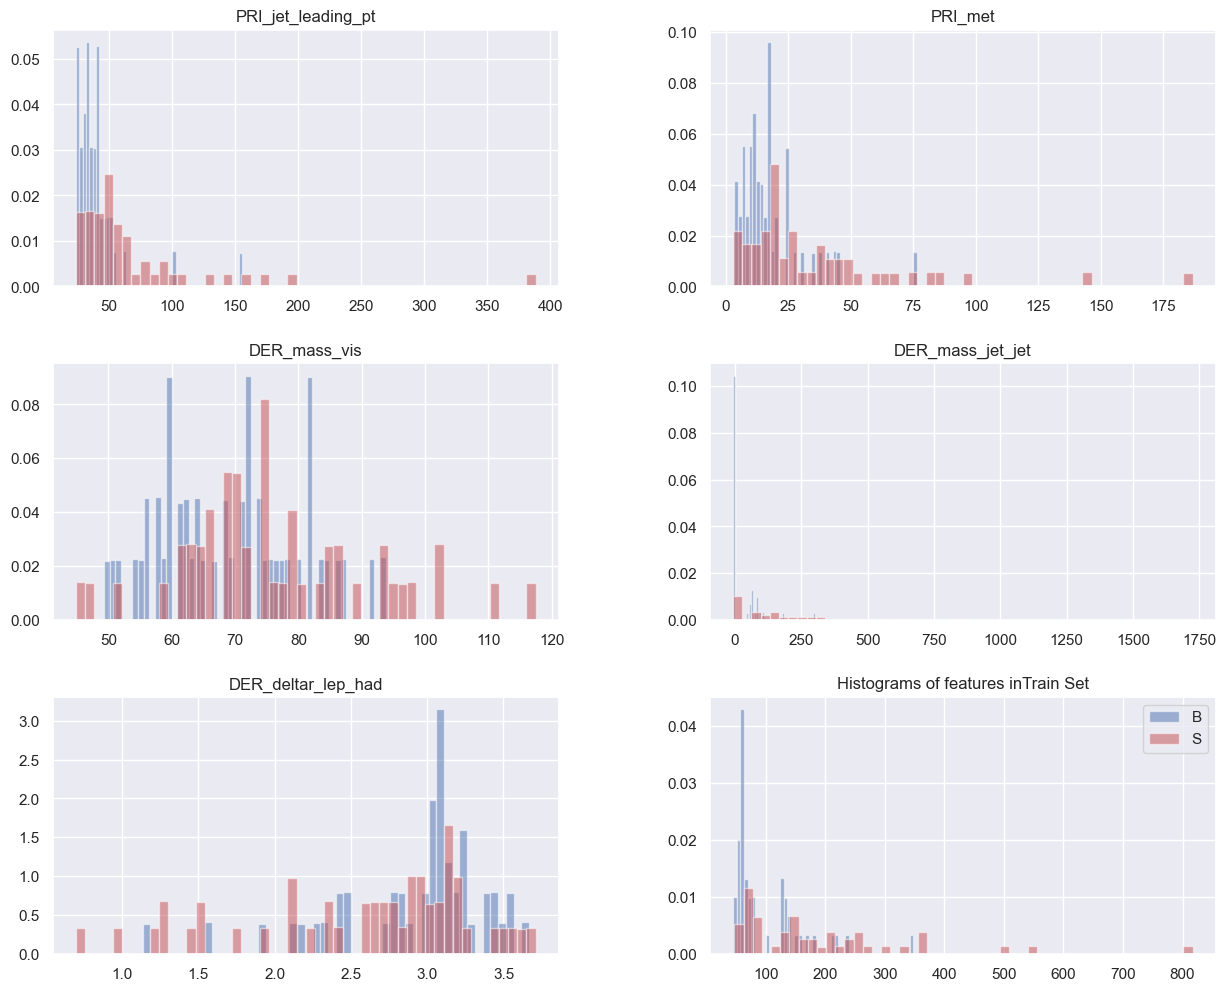

In [15]:
# Show data summary
visualize.show_histogram()

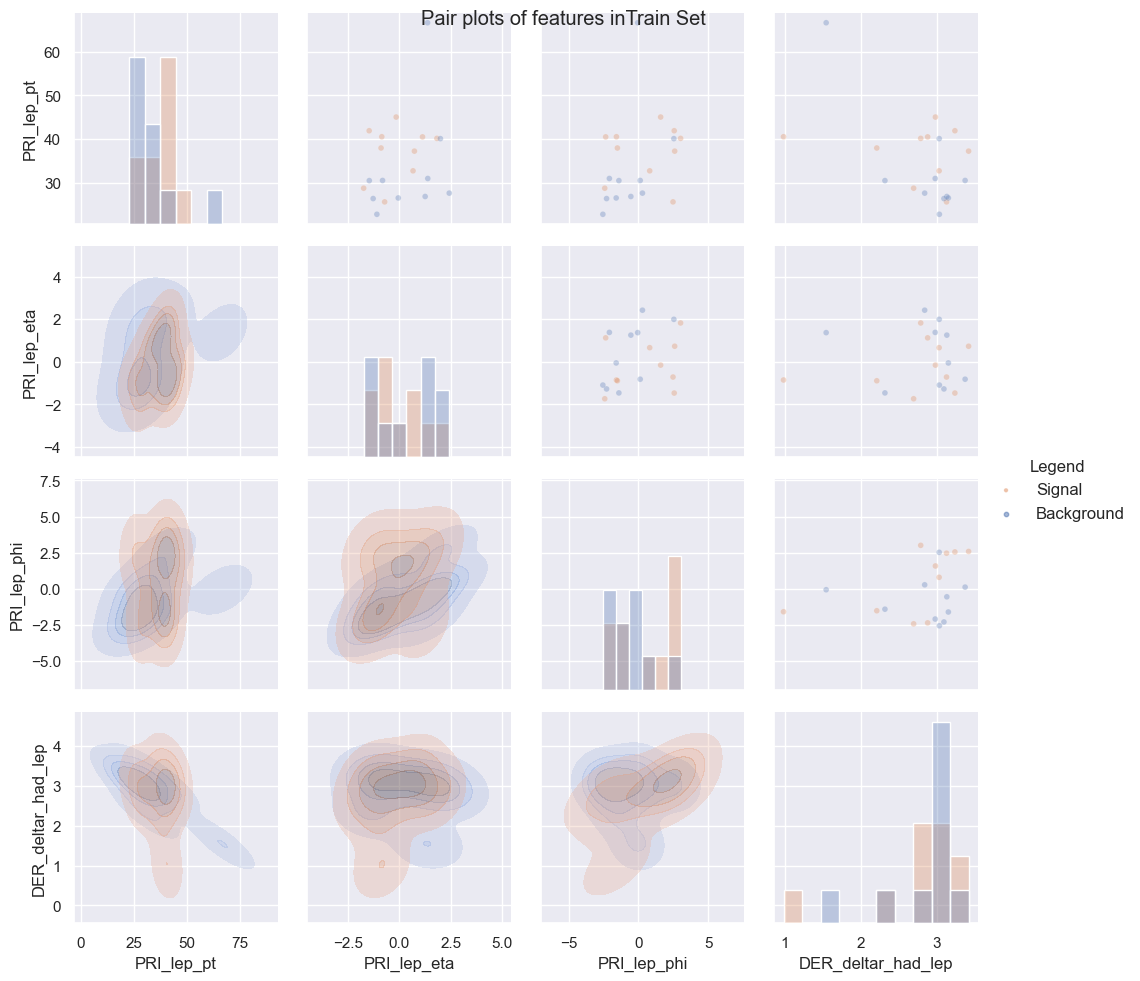

In [16]:
# Show data summary
visualize.show_pair_plots()

***
# Systematics
***
We demonstrate how `Systematics` class can be used to add systematics to a dataset

### ⚠️ Note:
`Systematics` class is one of the input of the submitted model, Participants are free to use this class and introduce systematics in their datasets

In [17]:
class Syst():
    def __init__(self, data):

        self.data = data
        self.columns = ['PRI_lep_pt', 'PRI_lep_eta','PRI_had_eta', 'DER_deltar_had_lep']
        print("==========================================")
        print("Systematics")
        print("==========================================")


    def add_systematics_to_train_data(self):
        print("[*] Adding systematics to Train set")
        # generate tes value uniformly between 0.9 and 1.1
        tes = round(np.random.uniform(0.9, 1.10), 2)
        print(f"[*] --- tes: {tes}")
        # apply systematics
        train_data_with_systematics = Systematics(
            data=self.data.train_set["data"],
            tes=tes
        ).data

        self.train_set_with_systematics = {
            "data": train_data_with_systematics,
            "labels": self.data.train_set["labels"],
            "weights": self.data.train_set["weights"],
            "settings": self.data.train_set["settings"]
        }

    
    def visualize_train_set(self):
        train_visualize = Dataset_visualise(
            data=data.train_set["data"],
            weights=data.train_set["weights"],
            labels=data.train_set["labels"],
            name="Train Set"
        ) 
        train_visualize.pair_plots(columns=self.columns)

    def visualize_train_set_with_systematics(self):
        train_syst_visualize = Dataset_visualise(
            data=self.train_set_with_systematics["data"],
            weights=self.train_set_with_systematics["weights"],
            labels=self.train_set_with_systematics["labels"],
            name="Train Set with systematics"
        ) 
        train_syst_visualize.pair_plots(columns=self.columns)
    

In [18]:
# Intiialize Program
syst = Syst(data=data)

Systematics


In [19]:
# Add systematics to trian data
systematics_train = syst.add_systematics_to_train_data()

[*] Adding systematics to Train set
[*] --- tes: 0.97


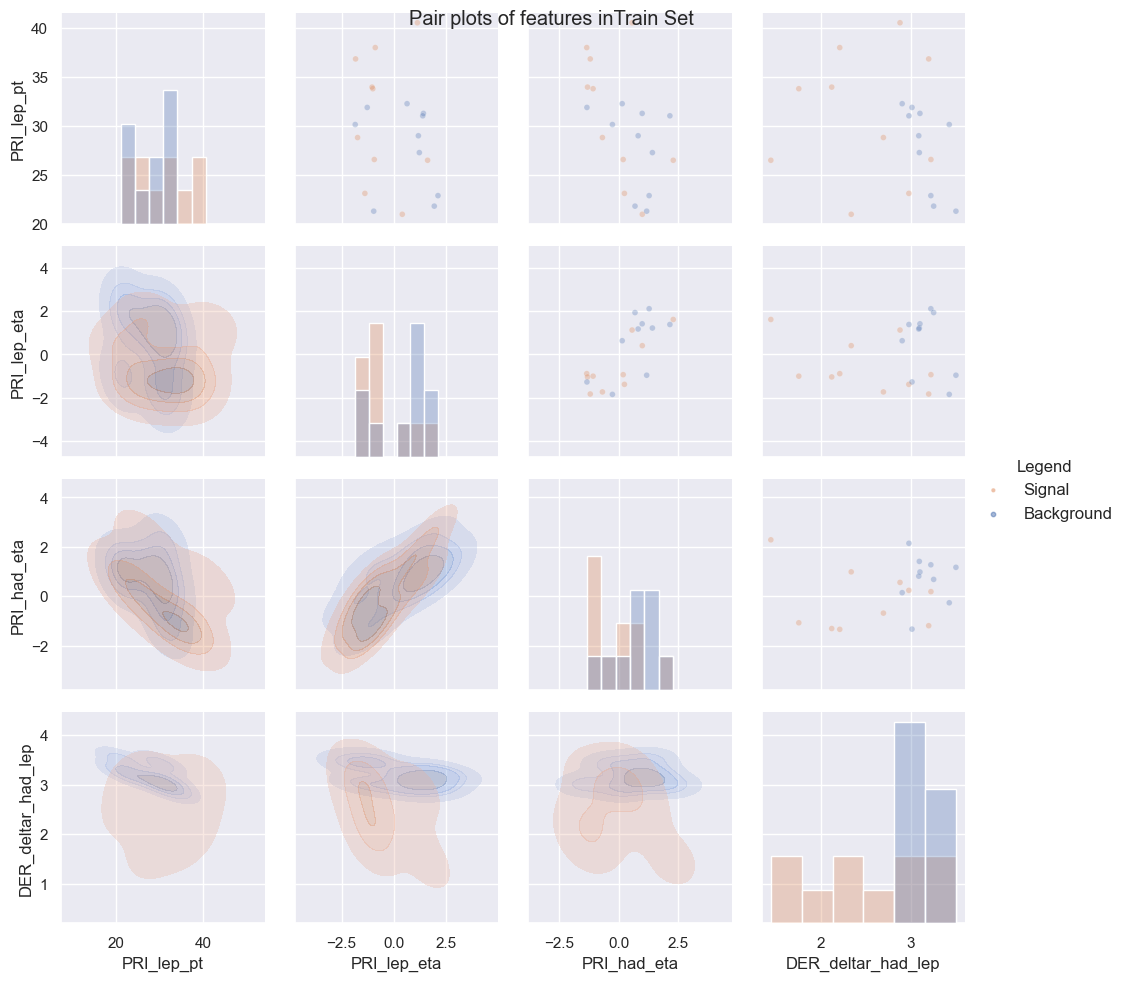

In [20]:
# Pair plots of orignal train set
syst.visualize_train_set()

In [21]:
# Pair plots of train set with systematics
syst.visualize_train_set_with_systematics()

ValueError: Length of values (100) does not match length of index (64)

***
# Program
***
**`Ingestion program`** is responsible to run the submission of a participant on Codabench platform. **`Program`** is a simplified version of the **Ingestion Program** to show to participants how it runs a submission.
1. Train a model on train data
2. Predict using Test data

In [ ]:
class Program():

    def __init__(self, data):

        # used to keep object of Model class to run the submission
        self.model = None
        # object of Data class used here to get the train and test sets
        self.data = data

        # results
        self.results = []

        print("==========================================")
        print("Program")
        print("==========================================")
    
    def initialize_submission(self):
        print("[*] Initializing Submmited Model")
        self.model = Model(
            train_set=self.data.train_set,
            systematics=Systematics
        )

    def fit_submission(self):
        print("[*] Calling fit method of submitted model")
        self.model.fit()

    def predict_submission(self):
        print("[*] Calling predict method of submitted model")
        # get set indices (0-9)
        set_indices = np.arange(0, 10)
        # get test set indices per set (0-99)
        test_set_indices = np.arange(0, 100)

        # create a product of set and test set indices all combinations of tuples
        all_combinations = list(product(set_indices, test_set_indices))

        results_dict = {}
        for set_index, test_set_index in all_combinations:

            test_set = self.data.test_sets[set_index][test_set_index]
            predicted_dict = self.model.predict(test_set)
            predicted_dict["test_set_index"] = test_set_index

            print(f"[*] - mu_hat: {predicted_dict['mu_hat']} - delta_mu_hat: {predicted_dict['delta_mu_hat']} - p16: {predicted_dict['p16']} - p84: {predicted_dict['p84']}")

            if set_index not in results_dict:
                results_dict[set_index] = []

            results_dict[set_index].append(predicted_dict)

        # prepare results for scoring
        self.results = []
        for i in range(0, 10):
            set_result = results_dict[i]
            mu_hats, delta_mu_hats, p16, p84 = [], [], [], []
            for test_set_dict in set_result:
                mu_hats.append(test_set_dict["mu_hat"])
                delta_mu_hats.append(test_set_dict["delta_mu_hat"])
                p16.append(test_set_dict["p16"])
                p84.append(test_set_dict["p84"])

            ingestion_result_dict = {
                "mu_hats": mu_hats,
                "delta_mu_hats": delta_mu_hats,
                "p16": p16,
                "p84": p84,
            }
            self.results.append(ingestion_result_dict)

In [ ]:
# Intiialize Program
program = Program(data=data)

In [ ]:
# Initialize submitted model
program.initialize_submission()

In [ ]:
# Call fit method of submitted model
program.fit_submission()

In [ ]:
# Call predict method of submitted model
program.predict_submission()

***
# Score
***
1. Compute Scores
2. Visualize Scores


In [ ]:
class Score():

    def __init__(self, data, program):

        self.data = data
        self.program = program

        print("==========================================")
        print("Score")
        print("==========================================")

    def compute_scores(self):
        print("[*] Computing scores")

        # loop over ingestion results
        self.rmses, self.maes, self.p16, self.p84, self.mus, self.mu_hats, self.intervals, self.coverages, self.quantiles_scores = [], [], [], [], [], [], [], [], []
        all_mus, all_p16s, all_p84s = [], [], []
        for i, (ingestion_result, test_set) in enumerate(zip(self.program.results, self.data.test_sets)):
            # just get the first test set mu
            mu = test_set[0]["settings"]["ground_truth_mu"]
            mu_hats = ingestion_result["mu_hats"]
            delta_mu_hats = ingestion_result["delta_mu_hats"]
            p16s = ingestion_result["p16"]
            p84s = ingestion_result["p84"]

            all_mus.extend(np.repeat(mu, len(p16s)))
            all_p16s.extend(p16s)
            all_p84s.extend(p84s)

            set_rmses, set_maes = [], []
            for mu_hat, delta_mu_hat in zip(mu_hats, delta_mu_hats):
                set_rmses.append(self.RMSE_score(mu, mu_hat, delta_mu_hat))
                set_maes.append(self.MAE_score(mu, mu_hat, delta_mu_hat))
            set_interval, set_coverage, set_quantiles_score = self.Quantiles_Score(np.repeat(mu, len(p16s)), np.array(p16s), np.array(p84s))

            set_mae = np.mean(set_maes)
            set_rmse = np.mean(set_rmses)

            print("------------------")
            print(f"Set {i}")
            print("------------------")
            print(f"MAE (avg): {set_mae}")
            print(f"RMSE (avg): {set_rmse}")
            print(f"Interval: {set_interval}")
            print(f"Coverage: {set_coverage}")
            print(f"Quantiles Score: {set_quantiles_score}")

            # Save set scores in lists
            self.mus.append(mu)
            self.p16.append(p16s)
            self.p84.append(p84s)
            self.mu_hats.append(mu_hats)
            self.rmses.append(set_rmse)
            self.maes.append(set_mae)
            self.intervals.append(set_interval)
            self.coverages.append(set_coverage)
            self.quantiles_scores.append(set_quantiles_score)

        overall_interval, overall_coverage, overall_quantiles_score = self.Quantiles_Score(np.array(all_mus), np.array(all_p16s), np.array(all_p84s))

        print("\n\n==================")
        print("Overall Score")
        print("==================")
        print(f"[*] --- RMSE: {round(np.mean(self.rmses), 3)}")
        print(f"[*] --- MAE: {round(np.mean(self.maes), 3)}")
        print(f"[*] --- Interval: {round(overall_interval, 3)}")
        print(f"[*] --- Coverage: {round(overall_coverage, 3)}")
        print(f"[*] --- Quantiles score: {round(overall_quantiles_score, 3)}")

    def RMSE_score(self, mu, mu_hat, delta_mu_hat):
        """Compute the sum of MSE and MSE2."""

        def MSE(mu, mu_hat):
            """Compute the mean squared error between scalar mu and vector mu_hat."""
            return np.mean((mu_hat - mu) ** 2)

        def MSE2(mu, mu_hat, delta_mu_hat):
            """Compute the mean squared error between computed delta_mu = mu_hat - mu and delta_mu_hat."""
            adjusted_diffs = (mu_hat - mu)**2 - delta_mu_hat**2
            return np.mean(adjusted_diffs**2)

        return np.sqrt(MSE(mu, mu_hat) + MSE2(mu, mu_hat, delta_mu_hat))

    def MAE_score(self, mu, mu_hat, delta_mu_hat):
        """Compute the sum of MAE and MAE2."""

        def MAE(mu, mu_hat):
            """Compute the mean absolute error between scalar mu and vector mu_hat."""
            return np.mean(np.abs(mu_hat - mu))

        def MAE2(mu, mu_hat, delta_mu_hat):
            """Compute the mean absolute error based on the provided definitions."""
            adjusted_diffs = np.abs(mu_hat - mu) - delta_mu_hat
            return np.mean(np.abs(adjusted_diffs))

        return MAE(mu, mu_hat) + MAE2(mu, mu_hat, delta_mu_hat)

    def Quantiles_Score(self, mu, p16, p84, eps=1e-3):

        def Interval(p16, p84):
            """Compute the average of the intervals defined by vectors p16 and p84."""
            return np.mean(p84 - p16)

        def Coverage(mu, p16, p84):
            """Compute the fraction of times scalar mu is within intervals defined by vectors p16 and p84."""
            return_coverage = np.mean((mu >= p16) & (mu <= p84))
            return return_coverage

        def f(x, n_tries, max_coverage=1e4, one_sigma = 0.6827):
                sigma68 = np.sqrt(((1-one_sigma)*one_sigma*n_tries))/n_tries

                if (x >= one_sigma-2*sigma68 and x <= one_sigma+2*sigma68):
                    out = 1
                elif (x < one_sigma-2*sigma68):
                    out = 1 + abs((x-(one_sigma-2*sigma68))/sigma68)**4
                elif (x > one_sigma+2*sigma68):
                    out = 1 + abs((x-(one_sigma+2*sigma68))/sigma68)**3
                return out

        coverage = Coverage(mu, p16, p84)
        interval = Interval(p16, p84)
        score = -np.log((interval + eps) * f(coverage, n_tries=mu.shape[0]))
        return interval, coverage, score

    def visualize_scatter(self):
        plt.figure(figsize=(6, 4))
        for i, (ingestion_result, test_set) in enumerate(zip(self.program.results, self.data.test_sets)):
            # just get the first test set mu
            mu = test_set[0]["settings"]["ground_truth_mu"]
            mu_hat = np.mean(ingestion_result["mu_hats"])
            plt.scatter(mu, mu_hat, c='b', marker='o')
        
        plt.xlabel('Ground Truth $\mu$')
        plt.ylabel('Predicted $\mu$ (averaged for 100 test sets)')
        plt.title('Ground Truth vs. Predicted $\mu$ Values')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()

    def visualize_coverage(self):

        rows = 5
        cols = 2
        total_plots = rows * cols

        plot_height = 10

        fig, axes = plt.subplots(rows, cols, figsize=(12, rows * plot_height))
        axes = axes.flatten()

        for idx, (mu, mu_hats, p16s, p84s) in enumerate(zip(self.mus, self.mu_hats, self.p16, self.p84)):

             # plot horizontal lines from p16 to p84
            for i, (p16, p84) in enumerate(zip(p16s, p84s)):
                axes[idx].hlines(y=i, xmin=p16, xmax=p84, colors='b', label='p16-p84')

            axes[idx].vlines(x=mu, ymin=0, ymax=len(p16s), colors='r', linestyles='dashed')
            axes[idx].set_xlabel('mu')
            axes[idx].set_ylabel('psuedo-experiments')
            axes[idx].set_title(f'mu distribution - Set_{idx}')
            
        plt.show()


In [ ]:
# Initialize Score
score = Score(data=data, program=program)

In [ ]:
# Compute Score
score.compute_scores()

In [ ]:
# Visualize scatter plot of ground truth mu and predicted mu
score.visualize_scatter()

In [ ]:
# Visualize coverage
score.visualize_coverage()

***
# Submissions
***

### **Unit Testing**

It is <b><span style="color:red">important that you test your submission files before submitting them</span></b>. All you have to do to make a submission is modify the file <code>model.py</code> in the <code>sample_code_submission/</code> directory, then run this test to make sure everything works fine. This is the actual program that will be run on the server to test your submission.
<br>
Keep the sample code simple.<br>

<code>python3</code> is required for this step

### **Test Ingestion Program**

In [ ]:
!python3 $program_dir/ingestion.py

### **Test Scoring Program**

In [ ]:
!python3 $score_dir/score.py

### **Prepare the submission**

In [ ]:
import datetime
from data_io import zipdir
the_date = datetime.datetime.now().strftime("%y-%m-%d-%H-%M")
code_submission = 'FU-HEP-code_submission_' + the_date + '.zip'
zipdir(code_submission, submission_dir)
print("Submit : " + code_submission + " to the compeition")